In [1]:
# In this notebook, we will evaluate the results of the HIT dataset training runs


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import json
import logging

logging.basicConfig(level=logging.INFO)

from conv_ae_3d.models.baseline_model import ConvAutoencoderBaseline
from scipy.spatial.distance import directed_hausdorff

from src.interface_representation.interface_types import InterfaceType
from eval_utils import read_loss_curve_from_file, load_dataset, load_model, run_inference, get_phi_sharp, dice_coefficient, get_phi_sharp_pred_and_gt

base_output_dir = pathlib.Path('./../../output/lassen')
files = list(base_output_dir.glob('interfacial_ae_v23_*'))

print(len(files))


9


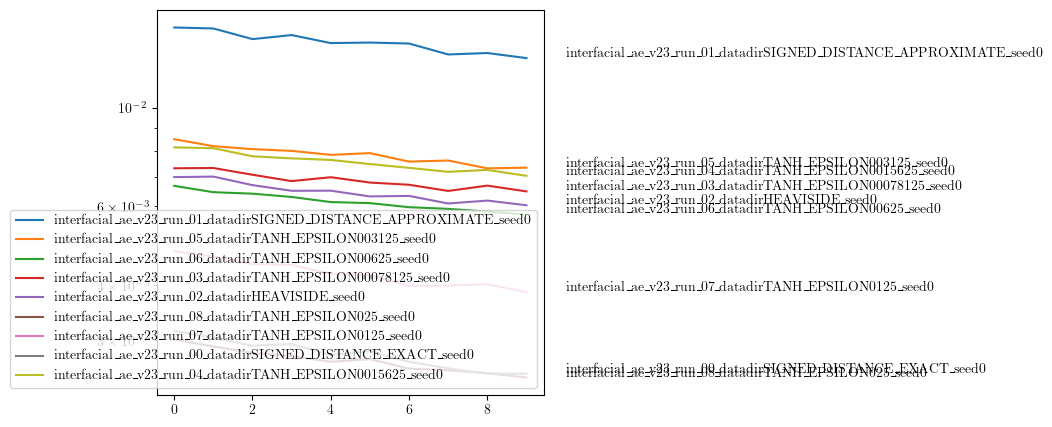

In [3]:

# Compare all the loss curves on one axis


name_to_loss = {}

for f in files:
    name_to_loss[f] = read_loss_curve_from_file(f)

fig, ax = plt.subplots(figsize=(5, 5))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
    
ax.legend()
ax.set_yscale('log')
plt.show()



In [4]:
# Functions to group the data by interface type and epsilon

def extract_interface_type(outdir):
    
    final_part = '_'.join(outdir.stem.split('_')[5:-1])

    str_to_type = {
        'datadirTANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'datadirHEAVISIDE': InterfaceType.HEAVISIDE,
        'datadirSIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'datadirSIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-1])
    
    str_to_epsilon = {
        'datadirTANH_EPSILON00078125': 0.0078125,
        'datadirTANH_EPSILON0015625': 0.015625,
        'datadirTANH_EPSILON003125': 0.03125,
        'datadirTANH_EPSILON00625': 0.0625,
        'datadirTANH_EPSILON0125': 0.125,
        'datadirTANH_EPSILON025': 0.25,
        'datadirHEAVISIDE': None,
        'datadirSIGNED_DISTANCE_EXACT': None,
        'datadirSIGNED_DISTANCE_APPROXIMATE': None,
    }
    
    return str_to_epsilon[final_part]


def get_model_path(outdir):
    return outdir / 'model-20.pt'


def get_dataset_path(interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')
    

In [5]:
outdir_to_params = {}

for f in files:
    interfacetype = extract_interface_type(f)
    epsilon = extract_epsilon(f)
    model_path = get_model_path(f)
    dataset_path = get_dataset_path(interfacetype, epsilon)
    
    assert model_path.exists()
    assert dataset_path.exists(), f'{dataset_path} does not exist'
    
    params = {
        'interface_type': interfacetype,
        'epsilon': epsilon,
        'model_path': model_path,
        'dataset_path': dataset_path
    }
    
    outdir_to_params[f] = params
    
# Sort

outdir_to_params = {key: outdir_to_params[key] for key in sorted(outdir_to_params.keys(), key=lambda x: x.stem)}

print(outdir_to_params)

{PosixPath('../../output/lassen/interfacial_ae_v23_run_00_datadirSIGNED_DISTANCE_EXACT_seed0'): {'interface_type': <InterfaceType.SIGNED_DISTANCE_EXACT: 2>, 'epsilon': None, 'model_path': PosixPath('../../output/lassen/interfacial_ae_v23_run_00_datadirSIGNED_DISTANCE_EXACT_seed0/model-20.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')}, PosixPath('../../output/lassen/interfacial_ae_v23_run_01_datadirSIGNED_DISTANCE_APPROXIMATE_seed0'): {'interface_type': <InterfaceType.SIGNED_DISTANCE_APPROXIMATE: 3>, 'epsilon': None, 'model_path': PosixPath('../../output/lassen/interfacial_ae_v23_run_01_datadirSIGNED_DISTANCE_APPROXIMATE_seed0/model-20.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')}, PosixPath('../../output/lassen/interfacial_ae_v23

In [6]:
# Run inference for all

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    
    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000)
    model = load_model(params['model_path'])
    gts, preds = run_inference(dataset, model, N=250)
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time! 
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

../../output/lassen/interfacial_ae_v23_run_00_datadirSIGNED_DISTANCE_EXACT_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_818_Restart_000_0_patch_25.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/notebooks/ai_fluids_2025/eval_utils.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the de

Loading model to device: mps
Running inference on device: mps


  0%|          | 0/250 [00:00<?, ?it/s]/Users/murray/miniconda3/envs/mfe/lib/python3.12/site-packages/torch/nn/functional.py:4538: UserWarning: The operator 'aten::upsample_nearest3d.vec' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_nearest3d(input, output_size, scale_factors)
100%|██████████| 250/250 [04:03<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_01_datadirSIGNED_DISTANCE_APPROXIMATE_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE/2023-05-12-09-22-Folder_818_Restart_000_0_patch_25.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:03<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_02_datadirHEAVISIDE_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-05-12-09-22-Folder_818_Restart_000_0_patch_25.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_03_datadirTANH_EPSILON00078125_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_818_Restart_000_0_patch_25.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_04_datadirTANH_EPSILON0015625_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.015625/2023-05-12-09-22-Folder_818_Restart_000_0_patch_25.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_05_datadirTANH_EPSILON003125_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_192_Restart_002_0.102183_patch_57.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_06_datadirTANH_EPSILON00625_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625/2023-05-12-09-22-Folder_999_Restart_007_2_patch_4.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_07_datadirTANH_EPSILON0125_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_149_Restart_007_0.774119_patch_58.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v23_run_08_datadirTANH_EPSILON025_seed0


INFO:src.datasets.volumetric_datasets:Limiting number of samples to 25000
INFO:src.datasets.volumetric_datasets:Constructed splits of size (number of runs NOT snapshots): train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-05-12-09-22-Folder_892_Restart_002_0.271618_patch_38.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:conv_ae_3d.models.baseline_model:Constructed ConvAutoencoderBaseline with 54532165 parameters


Loading model to device: mps
Running inference on device: mps


100%|██████████| 250/250 [04:07<00:00,  1.01it/s]


In [7]:
# Go over each file, and load predictions, compute metrics from each volume

def filename_to_plot_label(filename):
    final_part = '_'.join(filename.stem.split('_')[5:-1])

    str_to_label = {
        'datadirTANH_EPSILON00078125': 'Tanh 1/128',
        'datadirTANH_EPSILON0015625': 'Tanh 1/64',
        'datadirTANH_EPSILON003125': 'Tanh 1/32',
        'datadirTANH_EPSILON00625': 'Tanh 1/16',
        'datadirTANH_EPSILON0125': 'Tanh 1/8',
        'datadirTANH_EPSILON025': 'Tanh 1/4',
        'datadirHEAVISIDE': 'Sharp',
        'datadirSIGNED_DISTANCE_EXACT': 'Exact SDF',
        'datadirSIGNED_DISTANCE_APPROXIMATE': 'Approx. SDF',
    }

    return str_to_label[final_part]

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    # Compute metrics
    # 2. Dice coefficient
    
    dices = []
    
    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
        'gts': gts,
        'preds': preds
    }
    

../../output/lassen/interfacial_ae_v23_run_00_datadirSIGNED_DISTANCE_EXACT_seed0
0.902913027621745
../../output/lassen/interfacial_ae_v23_run_01_datadirSIGNED_DISTANCE_APPROXIMATE_seed0
0.8897030577159278
../../output/lassen/interfacial_ae_v23_run_02_datadirHEAVISIDE_seed0
0.9567424247680564
../../output/lassen/interfacial_ae_v23_run_03_datadirTANH_EPSILON00078125_seed0
0.9549364000414204
../../output/lassen/interfacial_ae_v23_run_04_datadirTANH_EPSILON0015625_seed0
0.9487044329767332
../../output/lassen/interfacial_ae_v23_run_05_datadirTANH_EPSILON003125_seed0
0.9123124415076248
../../output/lassen/interfacial_ae_v23_run_06_datadirTANH_EPSILON00625_seed0
0.9386233081818559
../../output/lassen/interfacial_ae_v23_run_07_datadirTANH_EPSILON0125_seed0
0.915741772366758
../../output/lassen/interfacial_ae_v23_run_08_datadirTANH_EPSILON025_seed0
0.9226675594623184


In [8]:
# Sort by outdir

sorted_outdirs = sorted(outdir_to_metrics.keys(), key=lambda x: x.stem)

outdir_to_metrics = {key: outdir_to_metrics[key] for key in sorted_outdirs}


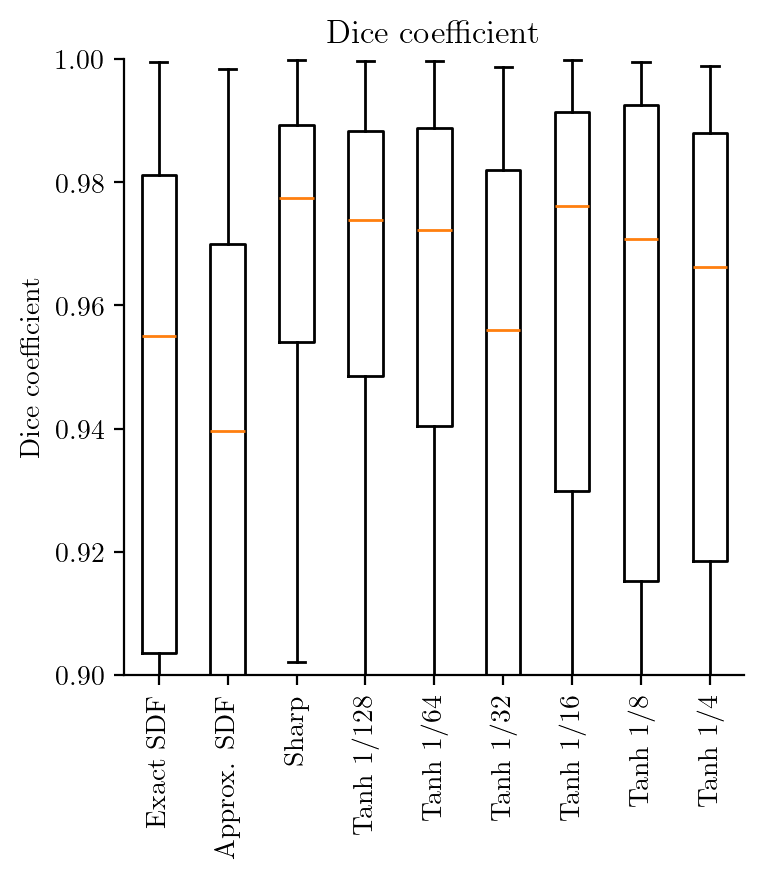

In [9]:
# Box plot of dice coefficients

def box_plot_dice_vals(outdir_to_metrics):
    fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
    data = [out['Dice'] for out in outdir_to_metrics.values()]
    labels = [filename_to_plot_label(out) for out in outdir_to_metrics.keys()]
    axs.boxplot(data, tick_labels=labels)
    axs.set_title('Dice coefficient')
    axs.set_ylabel('Dice coefficient')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.tick_params(axis='x', rotation=90)
    axs.set_ylim(0.9, 1)
    plt.show()
    
box_plot_dice_vals(outdir_to_metrics)

In [10]:

def compute_surface_area_density(phi):
    # Assume phi represents a volume fraction
    dx = 1 / phi.shape[-1]
    grad_phi = np.gradient(phi, dx)  # List of (64, 64, 64) arrays
    abs_grad_phi = np.sqrt(np.sum([g**2 for g in grad_phi], axis=0))
    surface_area = np.sum(abs_grad_phi)
    volume = np.sum(phi)
    return surface_area / volume

def compute_num_components(phi):
    labeled_arr, num_labels = ndimage.label(phi)
    return num_labels

def compute_volume_fraction(phi):
    return np.sum(phi) / phi.size

outdir_to_sigmas = {}

for outdir, params in outdir_to_params.items():
    gts = outdir_to_metrics[outdir]['gts']
    interfacetype = params['interface_type']
    epsilon = params['epsilon']
    plot_label = filename_to_plot_label(outdir)
    sigmas = []
    
    for gt in gts:
        phi = get_phi_sharp(gt, interfacetype)
        sigma = compute_surface_area_density(phi)
        sigmas.append(sigma)
        
    outdir_to_sigmas[outdir] = {
        'sigmas': sigmas,
        'epsilon': epsilon,
        'interface_type': interfacetype,
        'plot_label': plot_label
    }

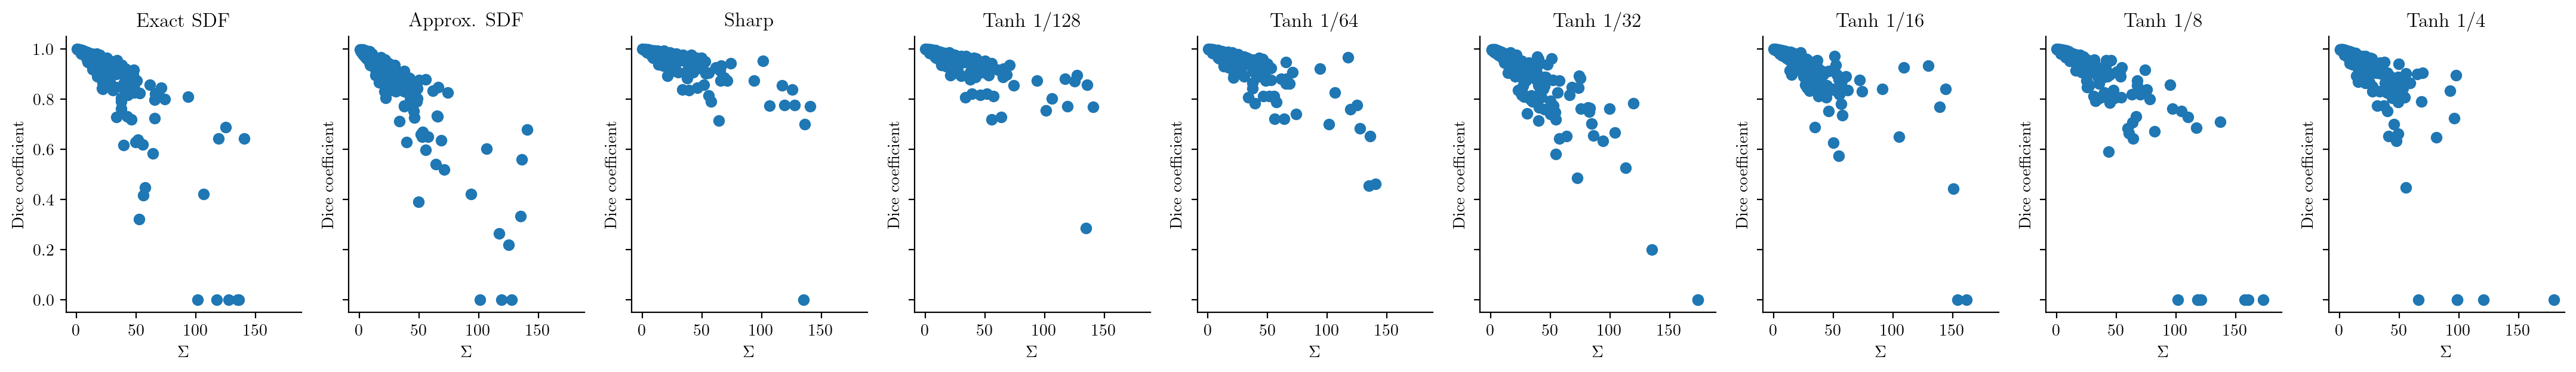

In [11]:
# Plot scatter plot of sigma vs dice coefficient for each interface type

fig, axs = plt.subplots(1, len(outdir_to_sigmas), figsize=(3 * len(outdir_to_sigmas), 3), dpi=200, sharey=True, sharex=True)

for i, (outdir, data) in enumerate(outdir_to_sigmas.items()):
    sigmas = data['sigmas']
    dices = outdir_to_metrics[outdir]['Dice']
    plot_label = data['plot_label']
    
    axs[i].scatter(sigmas, dices)
    axs[i].set_title(f'{plot_label}')
    axs[i].set_xlabel('$\\Sigma$')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.show()


In [12]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label

# Function to compute droplet PDF
def compute_droplet_pdf(arr):
    labeled_arr, num_labels = label(arr)
    sizes = np.bincount(labeled_arr.ravel())
    return sizes[1:]

# Group PDF data by interface type, epsilon, and mu value

interface_to_epsilon_to_mu_data = {}

for interface in InterfaceType:
    try:
        epsilons = sorted(set(params['epsilon'] for params in outdir_to_params.values() if params['interface_type'] == interface))
    except:
        epsilons = [None]
    interface_to_epsilon_to_mu_data[interface] = {epsilon: {mu: {'gt': [], 'pred': []} for mu in mus} for epsilon in epsilons}

print(interface_to_epsilon_to_mu_data)

for outdir, params in outdir_to_params.items():
    mu = params['mu']
    epsilon = params['epsilon']
    interface_type = params['interface_type']
    gts = outdir_to_metrics[outdir]['gts']
    preds = outdir_to_metrics[outdir]['preds']
    
    for gt, pred in zip(gts, preds):
        gt, pred = get_phi_sharp_pred_and_gt(pred, gt, interface_type)
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['gt'].extend(compute_droplet_pdf(gt))
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['pred'].extend(compute_droplet_pdf(pred))


NameError: name 'mus' is not defined

In [ ]:
def get_label(interfacetype, epsilon) -> str:
    if interfacetype == InterfaceType.TANH_EPSILON:
        return f'TANH_{epsilon}'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return 'SDF exact'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return 'SDF approx'
    elif interfacetype == InterfaceType.HEAVISIDE:
        return 'Heaviside'
    else:
        raise ValueError('Unknown interface type')
    
# Now change interface_to_epsilon_to_mu_data to label_to_mu_data

label_to_mu_data = {}

for interface, epsilon_to_mu_data in interface_to_epsilon_to_mu_data.items():
    for epsilon, mu_data in epsilon_to_mu_data.items():
        label = get_label(interface, epsilon)
        print(label)
        
        if label not in label_to_mu_data:
            label_to_mu_data[label] = {mu: {'gt': [], 'pred': []} for mu in mus}
        
        for mu in mus:
            label_to_mu_data[label][mu]['gt'].extend(mu_data[mu]['gt'])
            label_to_mu_data[label][mu]['pred'].extend(mu_data[mu]['pred'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the droplet PDFs for each label
fig, axs = plt.subplots(len(label_to_mu_data), 1, figsize=(4, 12), dpi=200, sharex=True, sharey=True)

colors = ['b', 'g', 'r']
num_bins = 25

for i, (label, mu_data) in enumerate(label_to_mu_data.items()):
    for j, mu in enumerate(mus):
        data = mu_data[mu]
        print(label, mu, len(data['gt']), len(data['pred']))
        min_bin = 1
        max_bin = 1e6
        bins = np.logspace(np.log10(min_bin), np.log10(max_bin), num_bins)

        axs[i].hist(data['gt'], bins=bins, alpha=0.5, label=f'GT mu={mu}', histtype='step', color=colors[j])
        axs[i].hist(data['pred'], bins=bins, alpha=0.5, label=f'Pred mu={mu}', histtype='step', linestyle='dashed', color=colors[j])
        axs[i].set_title(f'{label}')
        axs[i].set_xlabel('Droplet size')
        axs[i].set_ylabel('Frequency')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy import ndimage

def compute_surface_area_density(phi):
    # Assume phi represents a volume fraction
    dx = 1 / phi.shape[-1]
    grad_phi = np.gradient(phi, dx)  # List of (64, 64, 64) arrays
    abs_grad_phi = np.sqrt(np.sum([g**2 for g in grad_phi], axis=0))
    surface_area = np.sum(abs_grad_phi)
    volume = np.sum(phi)
    return surface_area / volume

def compute_num_components(phi):
    labeled_arr, num_labels = ndimage.label(phi)
    return num_labels

def compute_volume_fraction(phi):
    return np.sum(phi) / phi.size

plot_label_to_mu_to_sigmas = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_dices = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_num_components = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_volume_fraction = {label: {mu: [] for mu in mus} for label in label_to_mu_data}

for outdir, params in outdir_to_params.items():
    gts = outdir_to_metrics[outdir]['gts']
    interfacetype = params['interface_type']
    plot_label = get_label(interfacetype, params['epsilon'])
    mu = params['mu']
    dice_scores = outdir_to_metrics[outdir]['Dice']
    
    assert len(gts) == len(dice_scores)

    for gt in gts:
        phi = get_phi_sharp(gt, interfacetype)
        sigma = compute_surface_area_density(phi)
        vol_frac = compute_volume_fraction(phi)
        num_components = compute_num_components(phi)
        plot_label_to_mu_to_sigmas[plot_label][mu].append(sigma)
        plot_label_to_mu_to_num_components[plot_label][mu].append(num_components)
        plot_label_to_mu_to_volume_fraction[plot_label][mu].append(vol_frac)
        
    for dice in dice_scores:
        plot_label_to_mu_to_dices[plot_label][mu].append(dice)
        

In [ ]:

# Scatter plot of sigma vs dice coefficient
fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_sigmas):
    mu_to_sigmas = plot_label_to_mu_to_sigmas[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, sigma in mu_to_sigmas.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(sigma, dice_scores, alpha=0.25, label=f'$\\mu$={mu}')

    axs[i].set_title(label)
    axs[i].set_xlabel('$\\Sigma$')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xlim(0, 75)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot of num_components vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_num_components):
    mu_to_num_components = plot_label_to_mu_to_num_components[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_num_components.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}')

    axs[i].set_title(label)
    axs[i].set_xlabel('Num components')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
    
# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot of num_components vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_volume_fraction):
    mu_to_volfrac = plot_label_to_mu_to_volume_fraction[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_volfrac.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}')

    axs[i].set_title(label)
    axs[i].set_xlabel('Volume fraction')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage

def visualize_gt_pred(interface_type, mu, epsilon, sample_index):
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            gt = gts[sample_index]
            pred = preds[sample_index]
            
            gt = get_phi_sharp(gt, interface_type)
            pred = get_phi_sharp(pred, interface_type)
            
            dice = dice_coefficient(gt, pred)
            vol_frac = compute_volume_fraction(gt)
            sigma = compute_surface_area_density(gt)
            num_components = compute_num_components(gt)
            
            print(f'Dice: {dice}, Vol frac: {vol_frac}, Sigma: {sigma}, Num components: {num_components}')
            
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(gt[gt.shape[0] // 2], cmap='gray')
            axs[0].set_title('Ground Truth')
            axs[1].imshow(pred[pred.shape[0] // 2], cmap='gray')
            axs[1].set_title('Prediction')
            plt.show()



            fig = plt.figure(figsize=(6, 6), dpi=200)
            ax = fig.add_subplot(121, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                gt, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)
            
            ax = fig.add_subplot(122, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                pred, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)

            plt.tight_layout()
            break

# Example usage
visualize_gt_pred(InterfaceType.TANH_EPSILON, 2.0, 1/32, 0)

In [ ]:
def find_samples_in_volume_fraction_window(interface_type, mu, epsilon, volume_fraction_min, volume_fraction_max):
    sample_indices = []
    
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            for i, gt, pred in zip(range(len(gts)), gts, preds):
                gt = get_phi_sharp(gt, interface_type)
                pred = get_phi_sharp(pred, interface_type)
                dice = dice_coefficient(gt, pred)
                vol_frac = compute_volume_fraction(gt)
                if volume_fraction_min <= vol_frac <= volume_fraction_max:
                    sample_indices.append((i, dice))
            
    return sample_indices

# Example usage
sample_indices = find_samples_in_volume_fraction_window(InterfaceType.TANH_EPSILON, 1.0, 1/32, 0.25, 0.26)
print(sample_indices)

In [ ]:
# Visualise a good and bad sample with same volume fraction

visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 11)
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 42)

# Summary

 - 

# Next steps

  - 